In [1]:
import pandas as pd
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
import nltk
import numpy as np

## 處理斷字
nltk.download('stopwords')
nltk.download('punkt')
file = pd.read_csv('DLtrain.csv')
enc_sent, dec_sent1, dec_sent2 = list(), list(), list()
signs = [',', '-', '.', '!', '\'', ';', '#']
for line in file['Description']:
    line = line.lower()
    temp = word_tokenize(line)
    enc_sent.append([word for word in temp if word[0] not in signs])
    temp.insert(0, '<BOL>')
    dec_sent1.append([word for word in temp if word[0] not in signs])
    temp.remove('<BOL>')
    temp.append('<EOL>')
    dec_sent2.append([word for word in temp if word[0] not in signs])

test = pd.read_csv('test.csv')
enc_ts = list()
for line in test['Description']:
    line = line.lower()
    temp = word_tokenize(line)
    enc_ts.append([word for word in temp if word[0] not in signs])

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/309707001/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/309707001/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
A = enc_sent.copy()
A.extend(enc_ts.copy())

In [4]:
'''
en_dict = dict()
en_dict['<PAD>'] = 0
K = 1
for sentence in enc_sent:
    for word in sentence:
        if word not in en_dict:
            en_dict[word] = K
            K += 1

de_dict = dict()
de_dict['<PAD>'] = 0
de_dict['<BOL>'] = 1
de_dict['<EOL>'] = 2
K = 3
for sentence in dec_sent1:
    for word in sentence:
        if word not in de_dict:
            de_dict[word] = K
            K += 1

import torch
import torch.nn as nn
def data_setting(sentences1, sentences2, sentences3, en_dict, de_dict):
    enc_input, dec_input, dec_output = list(), list(), list()
    # 文字映射
    for idx in range(len(sentences1)):
        enc_input.append([en_dict[sentences1[idx][jdx]] if jdx < len(sentences1[idx]) else 0 for jdx in range(100)])
        dec_input.append([de_dict[sentences2[idx][jdx]] if jdx < len(sentences2[idx]) else 0 for jdx in range(100)])
        dec_output.append([de_dict[sentences3[idx][jdx]] if jdx < len(sentences3[idx]) else 0 for jdx in range(100)])
    return torch.LongTensor(enc_input), torch.LongTensor(dec_input), torch.LongTensor(dec_output)
enc_input, dec_input, dec_output = data_setting(enc_sent, dec_sent1, dec_sent2, en_dict, de_dict)
'''
sentences = list()
for i in range(len(A)):
    sentences.append([A[i][j] if j < len(A[i]) else "<PAD>" for j in range(100)])
import glove
from glove import Glove
from glove import Corpus
import numpy as np
corpus_model = Corpus()
corpus_model.fit(sentences, window = 10)
glove = Glove(no_components = 512, learning_rate = 0.05)
glove.fit(corpus_model.matrix, epochs = 100, no_threads = 40, verbose = False)
glove.add_dictionary(corpus_model.dictionary)
en_dict = glove.dictionary
enc_vector = glove.word_vectors
import torch
import torch.nn as nn
def data_setting(sentences1, en_dict):
    enc_input = list()
    # 文字映射
    for idx in range(len(sentences1)):
        enc_input.append([en_dict[sentences1[idx][jdx]] if jdx < len(sentences1[idx]) else en_dict['<PAD>'] for jdx in range(100)])
    return torch.LongTensor(enc_input)
enc_input = data_setting(enc_sent, en_dict)

In [5]:
d_model = 512
d_hid = 1024
d_key, d_value, d_query = 64, 64, 64
n_layer = 3
n_head = 2

In [6]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model = d_model, dropout = 0.1, N = 10000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p = dropout)
        position = np.array([[x/np.power(10000, 2*i/d_model) for i in range(d_model)] if x != 0 else np.zeros(d_model) for x in range(N)])
        position[1:, 0::2] = np.sin(position[1:, 0::2])
        position[1:, 1::2] = np.cos(position[1:, 1::2])
        self.position = torch.FloatTensor(position)
    def forward(self, X):
        x = torch.clone(X)
        x += self.position[:X.shape[1], :]
        return self.dropout(x)

In [7]:
def src_mask(sz):
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask
MASK = src_mask(400)

In [8]:
#weight = np.random.normal(0, 1, size = (len(en_dict), d_model))
#weight = torch.FloatTensor(weight)
enc_vector = torch.FloatTensor(enc_vector)

In [9]:
class Classification2(nn.Module):
    def __init__(self):
        super(Classification2, self).__init__()
        self.enc_embedding = nn.Embedding.from_pretrained(enc_vector, padding_idx = en_dict['<PAD>'], freeze = True
                                                          ,scale_grad_by_freq = True)
        #self.dec_embedding = nn.Embedding(len(de_dict), d_model, scale_grad_by_freq = True)
        self.pos_embedding = PositionalEncoding()
        self.Encoder = nn.TransformerEncoderLayer(d_model = d_model,
                                nhead = n_head,
                                dim_feedforward = d_hid,
                                dropout = 0.1,
                                activation = 'relu',
                                norm_first = True)
        #self.encoder = nn.TransformerEncoder(Encoder, num_layers = 2)
        self.Den = nn.Linear(100*d_model, d_hid, bias = True) #(詞向量維度, 字量)
        self.Den2 = nn.Linear(d_hid, 4, bias = True) #(詞向量維度, 字量)
        self.softmax = nn.Softmax() # 換成機率
    def forward(self, enc_input):
        x1 = self.enc_embedding(enc_input)  # (2000, 100, 512)
        x1 = self.pos_embedding.forward(x1) # (2000, 100, 512)
        #x1 = self.pos_embedding.forward(enc_input) # (2000, 100, 512)
        enc_output = self.Encoder(x1, src_mask = MASK) # (2000, 100, 512)
        enc_output = enc_output.reshape(enc_output.shape[0], -1)
        enc_output = nn.Dropout(0.1)(enc_output)
        enc_output = nn.ReLU()(self.Den(enc_output)) # (2000, d_hid)
        predict = nn.Softmax()(self.Den2(enc_output))
        
        return predict
    
def batch(enc_input, target,n):
    N = n//4
    I = np.random.choice(np.where(target == 0)[0], N, replace = False)
    for idx in range(1, 4):
        i = np.random.choice(np.where(target == idx)[0], N, replace = False)
        I = np.concatenate([I, i], axis = 0)
    return enc_input[I], target[I]

def tr_ts_split(x, y, p):
    n = int(x.shape[0]*p)
    N = n//4
    I = np.random.choice(np.where(y == 0)[0], N, replace = False)
    for idx in range(1, 4):
        i = np.random.choice(np.where(y == idx)[0], N, replace = False)
        I = np.concatenate([I, i], axis = 0)
    II = list(set([i for i in range(x.shape[0])]).difference(set(I)))
    return x[I], y[I], x[II], y[II]
y = torch.tensor(np.array(file['Category'] - 1))

In [11]:
EPOCHS = 1000
model = Classification2()
Loss = nn.CrossEntropyLoss() # ignore_index = 0
OPT = torch.optim.Adam(model.parameters(), lr = 0.01)
MILE = [i*50 for i in range(EPOCHS//50)]
scheduler = torch.optim.lr_scheduler.MultiStepLR(OPT, milestones=MILE, gamma=0.001)
losses = list()
ts_losses = list()
acces = list()
acces2 = list()
MIN = float('inf')
#X_train, y_train = batch(torch.FloatTensor(enc_vect), y, 10)
X_tr, y_tr, X_ts, y_ts = tr_ts_split(enc_input, y, 0.7)
for epoch in range(EPOCHS):
    X_train, y_train = batch(X_tr, y_tr, 400)
    output = model(X_train)
    y_hat = output.reshape(output.shape[0], 4)
    loss = Loss(y_hat, y_train)
    losses.append(float(loss))
    acc = (torch.argmax(output, axis = 1) == y_train).sum()/X_train.shape[0]
    acces.append(acc)
    X_test, y_test = batch(X_ts, y_ts, 400)
    output2 = model(X_test)
    y_hat2 = output2.reshape(output2.shape[0], 4)
    loss2 = Loss(y_hat2, y_test)
    ts_losses.append(float(loss2))
    acc2 = (torch.argmax(output2, axis = 1) == y_test).sum()/X_test.shape[0]
    acces2.append(acc2)
    if float(loss2) < MIN:
        MIN = float(loss2)
        flag = 0
        torch.save(model, 'text_classify_original9.pt')
    else:
        flag += 1
    if flag == 100:
        break
    OPT.zero_grad()
    loss.backward()
    #scheduler.step()
    print("Epoch {0} --train Loss:{1}; Acc:{2} --test Loss{3}; Acc{4}".format(epoch + 1, float(loss), float(acc),
                                                                             float(loss2), float(acc2)))
    OPT.step()

/tmp/ipykernel_1533739/2751404793.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predict = nn.Softmax()(self.Den2(enc_output))


Epoch 1 --train Loss:1.3873474597930908; Acc:0.26249998807907104 --test Loss1.3878674507141113; Acc0.24250000715255737
Epoch 2 --train Loss:1.3916910886764526; Acc:0.25 --test Loss1.3939683437347412; Acc0.25
Epoch 3 --train Loss:1.3887661695480347; Acc:0.2824999988079071 --test Loss1.390160322189331; Acc0.2750000059604645
Epoch 4 --train Loss:1.388515591621399; Acc:0.26499998569488525 --test Loss1.3904842138290405; Acc0.26750001311302185
Epoch 5 --train Loss:1.3878532648086548; Acc:0.25 --test Loss1.388706922531128; Acc0.25
Epoch 6 --train Loss:1.3851094245910645; Acc:0.30250000953674316 --test Loss1.3871809244155884; Acc0.2574999928474426
Epoch 7 --train Loss:1.3859235048294067; Acc:0.2574999928474426 --test Loss1.3877155780792236; Acc0.25
Epoch 8 --train Loss:1.383182168006897; Acc:0.2524999976158142 --test Loss1.384276270866394; Acc0.2549999952316284
Epoch 9 --train Loss:1.3841149806976318; Acc:0.2750000059604645 --test Loss1.3850277662277222; Acc0.25999999046325684
Epoch 10 --train

Epoch 72 --train Loss:1.328117847442627; Acc:0.4375 --test Loss1.3728110790252686; Acc0.2750000059604645
Epoch 73 --train Loss:1.3510234355926514; Acc:0.3149999976158142 --test Loss1.3607008457183838; Acc0.3125
Epoch 74 --train Loss:1.338011622428894; Acc:0.41999998688697815 --test Loss1.3628698587417603; Acc0.3050000071525574
Epoch 75 --train Loss:1.3324161767959595; Acc:0.45500001311302185 --test Loss1.3647369146347046; Acc0.3375000059604645
Epoch 76 --train Loss:1.3290705680847168; Acc:0.45500001311302185 --test Loss1.3676315546035767; Acc0.3100000023841858
Epoch 77 --train Loss:1.328628659248352; Acc:0.4449999928474426 --test Loss1.3623168468475342; Acc0.3100000023841858
Epoch 78 --train Loss:1.3367899656295776; Acc:0.42250001430511475 --test Loss1.3624563217163086; Acc0.3050000071525574
Epoch 79 --train Loss:1.3436360359191895; Acc:0.44999998807907104 --test Loss1.3677303791046143; Acc0.3050000071525574
Epoch 80 --train Loss:1.3345454931259155; Acc:0.4375 --test Loss1.370833277702

Epoch 142 --train Loss:1.276064395904541; Acc:0.45500001311302185 --test Loss1.3168740272521973; Acc0.3824999928474426
Epoch 143 --train Loss:1.249513864517212; Acc:0.4699999988079071 --test Loss1.3329464197158813; Acc0.3725000023841858
Epoch 144 --train Loss:1.2618687152862549; Acc:0.5600000023841858 --test Loss1.329431176185608; Acc0.36500000953674316
Epoch 145 --train Loss:1.2821910381317139; Acc:0.45249998569488525 --test Loss1.313716173171997; Acc0.39250001311302185
Epoch 146 --train Loss:1.2746918201446533; Acc:0.4749999940395355 --test Loss1.3086216449737549; Acc0.39250001311302185
Epoch 147 --train Loss:1.2366503477096558; Acc:0.5600000023841858 --test Loss1.2982335090637207; Acc0.4650000035762787
Epoch 148 --train Loss:1.242106556892395; Acc:0.512499988079071 --test Loss1.327576756477356; Acc0.3675000071525574
Epoch 149 --train Loss:1.2754156589508057; Acc:0.512499988079071 --test Loss1.3052053451538086; Acc0.4350000023841858
Epoch 150 --train Loss:1.252005696296692; Acc:0.562

Epoch 212 --train Loss:1.179636836051941; Acc:0.5950000286102295 --test Loss1.2709543704986572; Acc0.45500001311302185
Epoch 213 --train Loss:1.141746163368225; Acc:0.6274999976158142 --test Loss1.2610808610916138; Acc0.4625000059604645
Epoch 214 --train Loss:1.1483749151229858; Acc:0.6324999928474426 --test Loss1.2584563493728638; Acc0.47749999165534973
Epoch 215 --train Loss:1.1546837091445923; Acc:0.6725000143051147 --test Loss1.2620023488998413; Acc0.4675000011920929
Epoch 216 --train Loss:1.1620237827301025; Acc:0.6499999761581421 --test Loss1.2366942167282104; Acc0.5074999928474426
Epoch 217 --train Loss:1.1658421754837036; Acc:0.6000000238418579 --test Loss1.264316201210022; Acc0.5099999904632568
Epoch 218 --train Loss:1.1668606996536255; Acc:0.5899999737739563 --test Loss1.2241795063018799; Acc0.5274999737739563
Epoch 219 --train Loss:1.1621884107589722; Acc:0.6324999928474426 --test Loss1.2555989027023315; Acc0.4925000071525574
Epoch 220 --train Loss:1.2021418809890747; Acc:0.

Epoch 282 --train Loss:1.1155478954315186; Acc:0.6725000143051147 --test Loss1.2546039819717407; Acc0.48249998688697815
Epoch 283 --train Loss:1.0351775884628296; Acc:0.7875000238418579 --test Loss1.2486510276794434; Acc0.4675000011920929
Epoch 284 --train Loss:1.1161164045333862; Acc:0.699999988079071 --test Loss1.1950926780700684; Acc0.5625
Epoch 285 --train Loss:1.1071538925170898; Acc:0.6800000071525574 --test Loss1.2179656028747559; Acc0.5149999856948853
Epoch 286 --train Loss:1.069581389427185; Acc:0.737500011920929 --test Loss1.2043542861938477; Acc0.5600000023841858
Epoch 287 --train Loss:1.0913310050964355; Acc:0.7124999761581421 --test Loss1.1950128078460693; Acc0.5724999904632568
Epoch 288 --train Loss:1.0941705703735352; Acc:0.7024999856948853 --test Loss1.2128154039382935; Acc0.550000011920929
Epoch 289 --train Loss:1.0866918563842773; Acc:0.699999988079071 --test Loss1.1832386255264282; Acc0.5600000023841858
Epoch 290 --train Loss:1.085498571395874; Acc:0.6924999952316284


KeyboardInterrupt



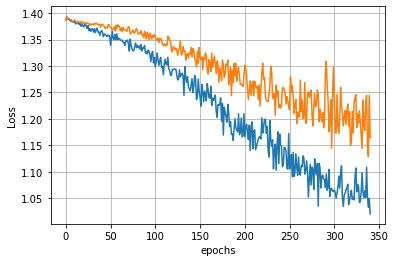

In [12]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(ts_losses)
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.grid()
plt.show()

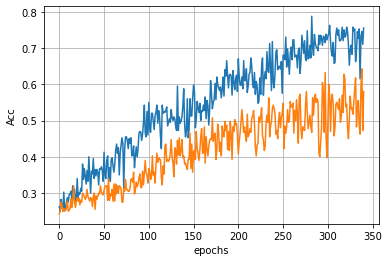

In [13]:
import matplotlib.pyplot as plt
plt.plot(acces)
plt.plot(acces2)
plt.ylabel('Acc')
plt.xlabel('epochs')
plt.grid()
plt.show()

In [15]:
(torch.argmax(model(X_test), axis = 1) == y_test).sum()/y_test.shape[0]

/tmp/ipykernel_1533739/2751404793.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predict = nn.Softmax()(self.Den2(enc_output))


tensor(0.6000)

In [24]:
MODEL = torch.load('text_classify_original9.pt')
test = pd.read_csv('test.csv')
enc_ts = list()
for line in test['Description']:
    line = line.lower()
    temp = word_tokenize(line)
    enc_ts.append([word for word in temp if word[0] not in signs])
XX = list()
# 文字映射
for idx in range(len(enc_ts)):
    XX.append([en_dict[enc_ts[idx][jdx]] if jdx < len(enc_ts[idx]) else 0 for jdx in range(100)])
XX = torch.tensor(XX)
Y = MODEL(XX)
RESULT = pd.DataFrame(np.array(torch.argmax(Y, axis = 1)), columns = ['Category']).reset_index()
RESULT.columns = ['Id','Category']
RESULT['Id'] = test['Id']
RESULT['Category'] += 1
RESULT.to_csv('SUBMISSION.csv', index = False)

/tmp/ipykernel_1533739/2751404793.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predict = nn.Softmax()(self.Den2(enc_output))


In [27]:
torch.argmax(Y, axis = 1)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3,
        3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 2,
        3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3,
        3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3,
        3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3,

In [17]:
(torch.argmax(MODEL(X_test), axis = 1) == y_test).sum()/y_test.shape[0]

/tmp/ipykernel_1533739/2751404793.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predict = nn.Softmax()(self.Den2(enc_output))


tensor(0.6075)

In [18]:
(torch.argmax(model(X_test), axis = 1) == y_test).sum()/y_test.shape[0]

/tmp/ipykernel_1533739/2751404793.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predict = nn.Softmax()(self.Den2(enc_output))


tensor(0.5975)